# Hey beth!

#### Figured it would actually be better to just give you a basic notebook with the uncorrected and the basic bkg corrected image process
#### This way you can just run it yourself, choose whatever images you want, as well as the colormaps etc.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from datetime import datetime
import os
import h5py
import re
import glob
import csv
import scipy.ndimage as nd
from scipy.ndimage import rotate
from scipy.interpolate import interp1d
import skimage as ski
from skimage.morphology import square,disk

%matplotlib notebook

In [2]:
#take a high charge, high background acceleration dataset

path = '/eos/experiment/awake/event_data/2024/09/14/*_2064*.h5' #LBDP2 in 2e14 plunger scan

files = glob.glob(path)
files=sorted(files)

print('Events Captured:', len(files))
#print(files)

Events Captured: 20


In [3]:
Date = '2024/09/14'
DATA_PATH = f'/eos/experiment/awake/event_data/{Date}'
event_files = os.listdir(DATA_PATH)

In [4]:
#event_files[963]

# Original image, straight from the event builder

In [46]:
def getNewSpecImage(event_array, SPECTRO_CAM, log=False, vmax=None, vmin=None, mf=False, mf_size=5, save = False, dpi=150):
    
    for i in event_array:
        try:
            selectedEvent = os.path.join(DATA_PATH, event_files[i])
            with h5py.File(selectedEvent, 'r') as selectedEventFile:
                eventImg = selectedEventFile['AwakeEventData'][f'TCC4.SPECTRO{SPECTRO_CAM}.DigiCam']['ExtractionImage']['image2D'][:]
                
                if mf:
                    eventImg = nd.median_filter(eventImg, size=mf_size)
                
                if log:
                    eventImg = np.log1p(eventImg)  
                          
                plt.figure(figsize=(8,6))
                stamp = int(selectedEvent[44:63])
                timestamp = pd.to_datetime(stamp)
                formatted_timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S')
                title_str = f'No corrections \n Event:{i}-{selectedEvent[69:]} \n {formatted_timestamp}'
                plt.title(title_str)
                plt.imshow(eventImg, cmap='Blues',vmax=vmax, vmin=vmin)
                plt.colorbar() 
                
                plt.show()
                
                if save:
                    # Make a safe filename from the title
                    safe_title = re.sub(r'[\\/*?:"<>|]', "_", title_str.replace("\n", "_"))
                    plt.savefig(rf"C:\Users\bethx\OneDrive\Documents\UCL_Masters\Research_Project\dissertation\_{safe_title}.png", dpi=dpi, bbox_inches='tight')

        except Exception as e:
            print(f"Failed to process event {i}: {e}")
            continue
            
    return eventImg

<IPython.core.display.Javascript object>


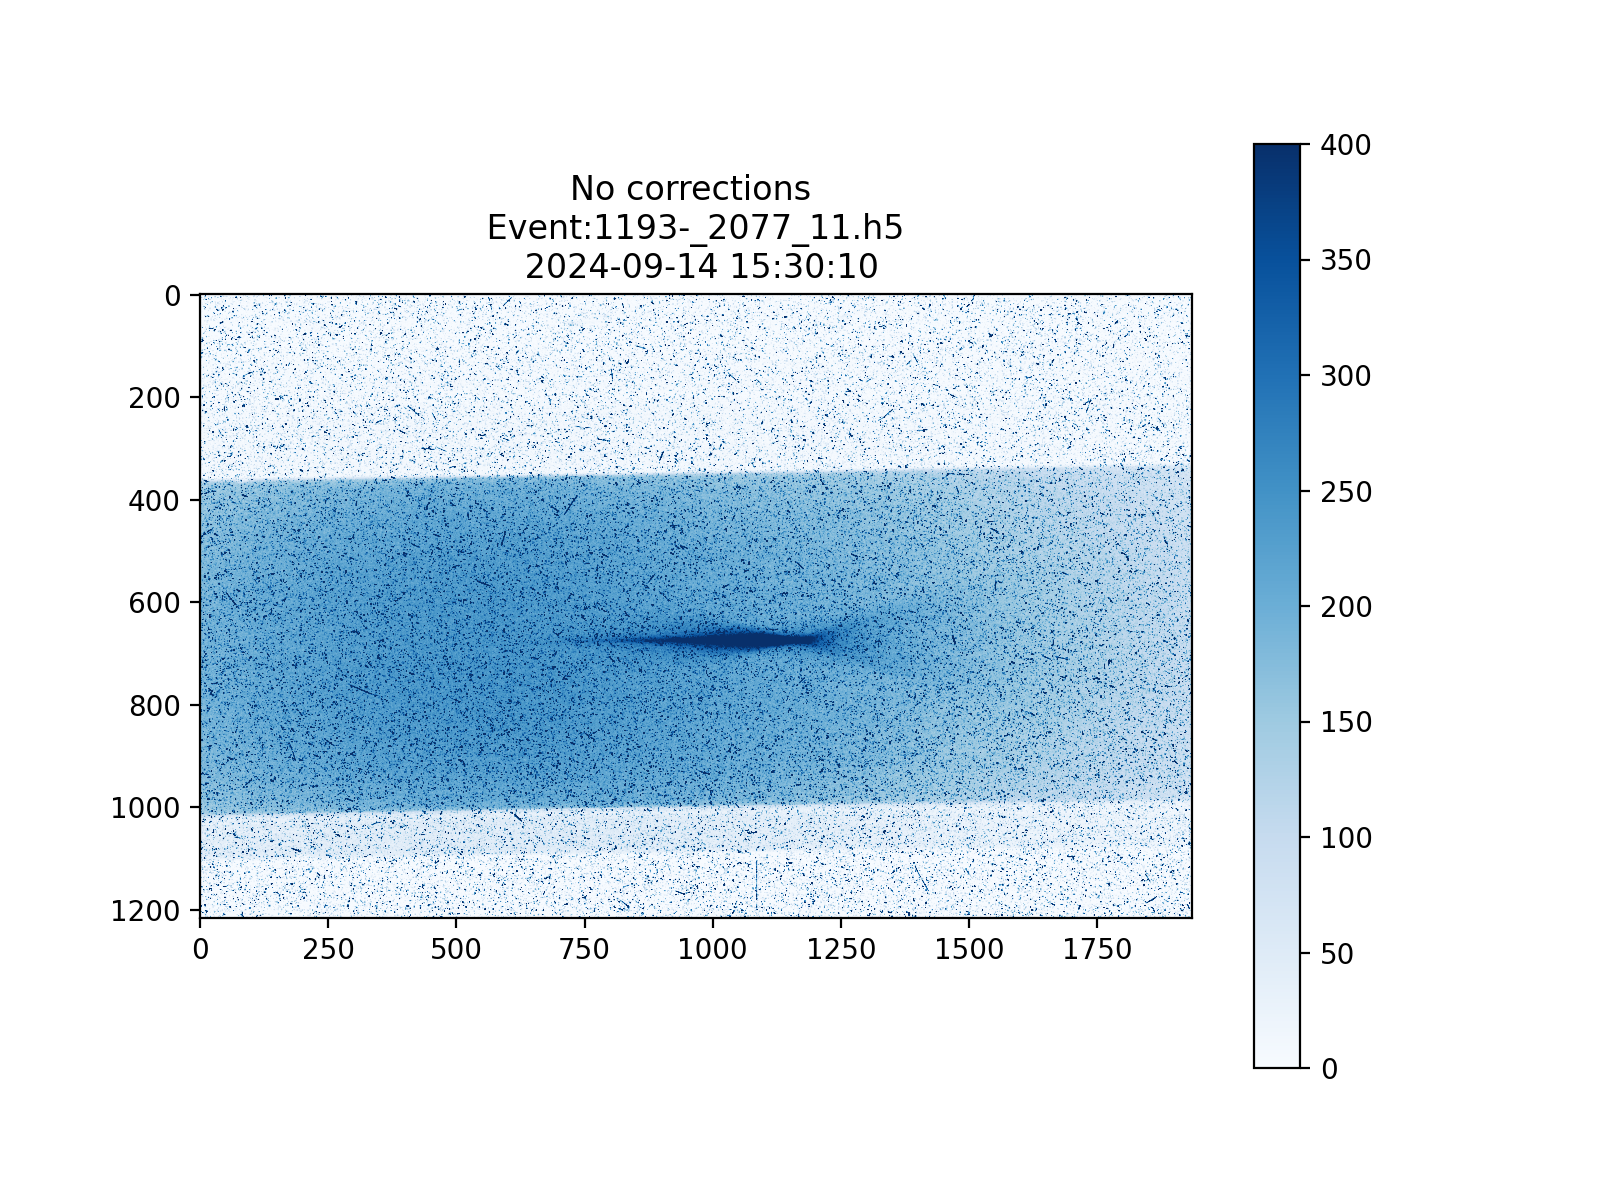

In [47]:
raw_image = getNewSpecImage([1193], 2, mf=False,log=False, vmax=400, vmin=0)

# Now just doing a basic rotation, which I choose as the best angle to align the image horizontally

#### hence the axhlines

In [7]:
def getNewSpecImage_rotated(event_array, SPECTRO_CAM, log=False, vmax=None, vmin=None, mf=False, mf_size=4, rot=0):

    for i in event_array:
        try:
            selectedEvent = os.path.join(DATA_PATH, event_files[i])
            with h5py.File(selectedEvent, 'r') as selectedEventFile:
                eventImg = selectedEventFile['AwakeEventData'][f'TCC4.SPECTRO{SPECTRO_CAM}.DigiCam']['ExtractionImage']['image2D'][:]

                if rot != 0:
                    eventImg = nd.rotate(eventImg, angle=rot, reshape=False)

                if mf:
                    eventImg = nd.median_filter(eventImg, size=mf_size)

                if log:
                    eventImg = np.log1p(eventImg)  

                plt.figure(figsize=(8,6))
                stamp = int(selectedEvent[44:63])
                timestamp = pd.to_datetime(stamp)
                formatted_timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S')
                plt.title(f'Rotation \n Event:{i}-{selectedEvent[69:]} \n {formatted_timestamp}')
                plt.imshow(eventImg, cmap='inferno', vmax=vmax, vmin=vmin)
                plt.colorbar() 
                
                #just putting in some horizontal lines to show alignment
                plt.axhline(360, linestyle='--', color='k')
                plt.axhline(990, linestyle='--', color='k')
                
                plt.show()

        except Exception as e:
            print(f"Failed to process event {i}: {e}")
            continue
            
    return eventImg

<IPython.core.display.Javascript object>


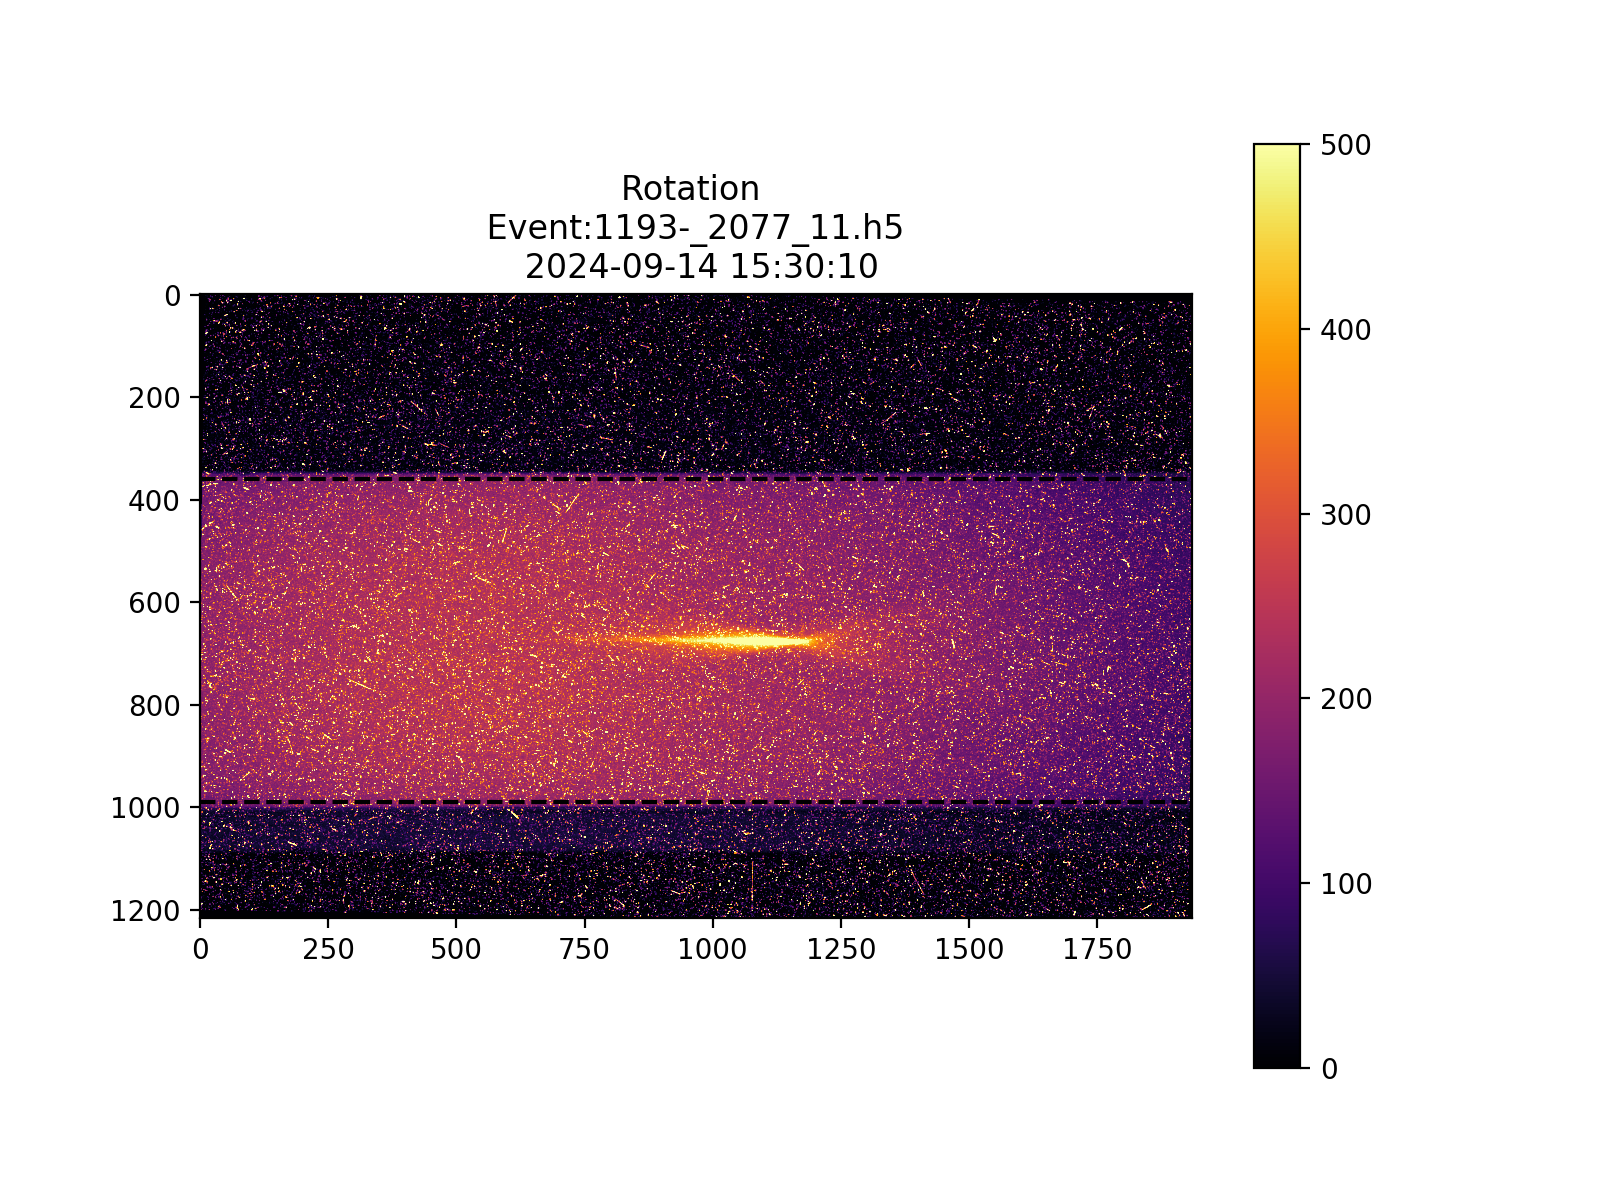

In [39]:
ex_data_lbdp = getNewSpecImage_rotated([1193], 2, mf=False, rot= -0.9, vmax=500, vmin=0)

# Now I do a rough background subtraction 

#### by taking 20 horizontal profiles across the screen at the edges (10 top, 10 bottom), averaging them into one and subtracting the result through the entire image

In [50]:
def getNewSpecImage_bgs(event_array, SPECTRO_CAM, log=False, vmax=None, vmin=None, mf=False, mf_size=4, rot=0):

    for i in event_array:
        try:
            selectedEvent = os.path.join(DATA_PATH, event_files[i])

            with h5py.File(selectedEvent, 'r') as selectedEventFile:
                eventImg = selectedEventFile['AwakeEventData'][f'TCC4.SPECTRO{SPECTRO_CAM}.DigiCam']['ExtractionImage']['image2D'][:]

                if rot != 0:
                    eventImg = nd.rotate(eventImg, angle=rot, reshape=False)

                if mf:
                    eventImg = nd.median_filter(eventImg, size=mf_size)

                if log:
                    eventImg = np.log1p(eventImg)  
                
                #I take 10 arbitrarily... it's better than one, but not so many that it gets close to the signal
                background_rows_1 = eventImg[355:365, :]
                background_rows_2 = eventImg[980:990, :]
                
                #average the profiles to one profile
                background_average_1 = np.mean(np.vstack((background_rows_1)), axis=0)
                background_average_2 = np.mean(np.vstack((background_rows_2)), axis=0)
                background_average = np.mean(np.vstack((background_rows_1, background_rows_2)), axis=0)
                
                backCorrectedImg = eventImg - background_average
                
                plt.figure(figsize=(8,6))
                stamp = int(selectedEvent[44:63])
                timestamp = pd.to_datetime(stamp)
                formatted_timestamp = timestamp.strftime('%Y-%m-%d %H:%M:%S')
                plt.title(f'Background Subtracted Image \n Event:{i}-{selectedEvent[69:]} \n {formatted_timestamp}')
                plt.imshow(backCorrectedImg, cmap='Blues', vmax=vmax, vmin=vmin)
                plt.colorbar() 
                
                plt.show()
                

        except Exception as e:
            print(f"Failed to process event {i}: {e}")
            continue

    return backCorrectedImg

<IPython.core.display.Javascript object>


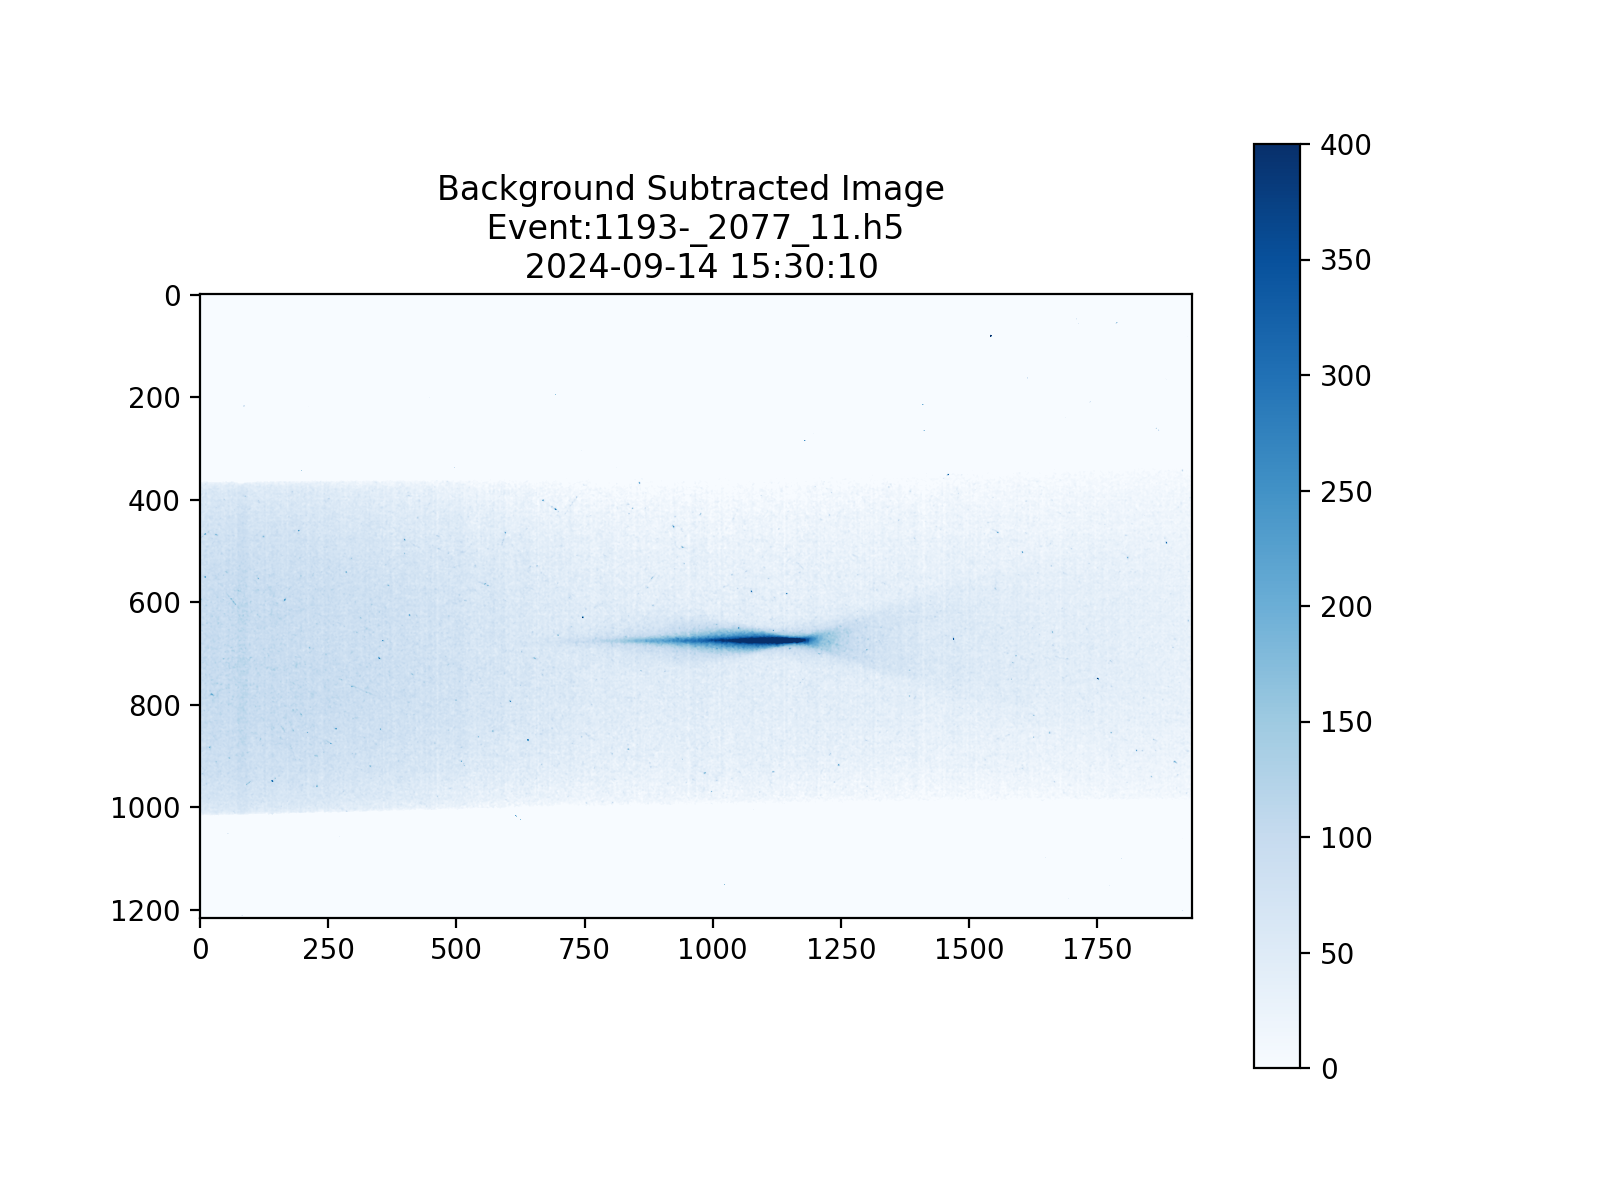

In [51]:
bg_img = getNewSpecImage_bgs([1193], 2, mf=True, vmax=400, vmin=0)

#### I've kept the z-scale constant throughout so you can easily see the effect. Cleary it removes 'some background' but you can still see the screen (as well as hot pixels causing vertical lineouts etc)

In [11]:
plt.imshow(bg_img)

<IPython.core.display.Javascript object>


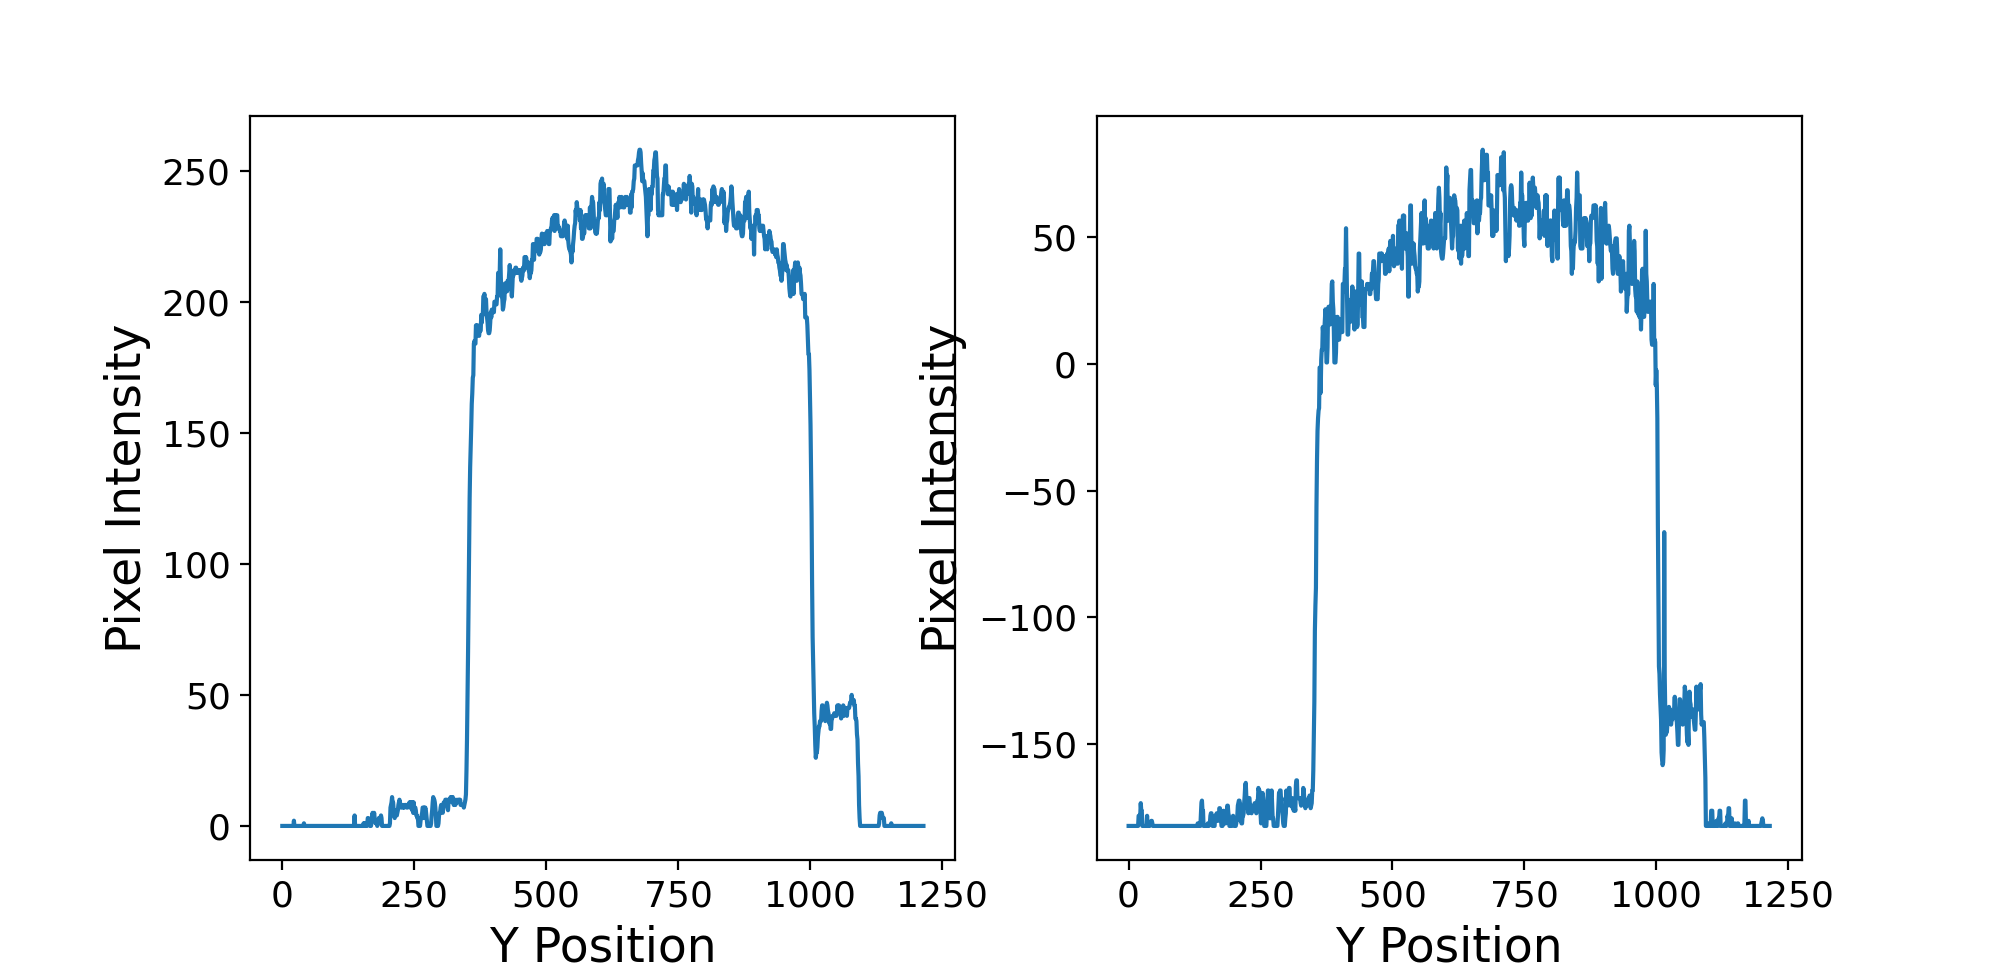

In [52]:
fig, axes = plt.subplots(1, 2)

x = np.arange(raw_image.shape[0])
data_w_median_filter = ski.filters.median(raw_image, footprint=disk(4)) 


# First subplot
axes[0].plot(x,data_w_median_filter[:,680])
axes[0].set_ylabel('Pixel Intensity',fontsize=17)
axes[0].set_xlabel('Y Position',fontsize=17)

axes[1].plot(x,bg_img[:,680])
axes[1].set_ylabel('Pixel Intensity',fontsize=17)
axes[1].set_xlabel('Y Position',fontsize=17)

axes[1].tick_params(axis='both', which='major', labelsize=13)
axes[0].tick_params(axis='both', which='major', labelsize=13)

# Write each spectro cam image to file

In [ ]:
def write_files(event, save = False, dpi=150):
    
    for i in np.arange(0,8,1):
        try:
            selectedEvent = os.path.join(DATA_PATH, event_files[event])
            with h5py.File(selectedEvent, 'r') as selectedEventFile:
                eventImg = selectedEventFile['AwakeEventData'][f'TCC4.SPECTRO{i}.DigiCam']['ExtractionImage']['image2D'][:]
                
            